In [1]:
#a notebook that implement random forest algo to gnerate facotr based on operation analyst data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
company = pd.read_excel('CompanyFactorData.xlsx', sheet_name="final_data")
#data is cleaned and winsorized

In [4]:
#create z-Score for company fundamentals data
company_data=company.iloc[:, 0:20].copy()
cols = list(company_data)
cols.remove('ID')
cols.remove('Company')
cols.remove('Date')
cols.remove('Year')
company_result=pd.DataFrame()
for col in cols:
    col_zscore = col+' z_score'
    company_data[col_zscore] = (company_data[col] - company_data[col].mean())/company_data[col].std()
    company_data=company_data.drop([col], axis=1)
company_result=company_result.append(company_data)

In [5]:
analyst_view=company.iloc[:,20:].copy()
final_data=pd.merge(company_result, analyst_view, left_index=True, right_index=True)
final_data

,ID,Company,Date,Year,Normalized EBIT z_score,Total Revenue z_score,Total Operating Expense z_score,Diluted EPS Excluding Extraordinary Items z_score,Basic EPS Excluding Extraordinary Items z_score,"Total Assets, Reported z_score",...,Recommendation - Number Of Buy,Recommendation - Number Of Hold,Recommendation - Number Of Sell,Recommendation - Number Of Strong Sell,Recommendation - Number Of No Opinion,Price Target - Mean,Price Target - Median,Price Target - High,Price Target - Low,Price Target - Standard Deviation
0,APO.N2009,APO.N,2009-12-31,2009,-0.679534,-0.578179,-0.524972,-1.512481,-1.508814,-0.537195,...,1,2,0,0,0,3.51563,3.4375,4.375,2.81250,0.66052
1,DPZ.N2017,DPZ.N,2017-12-31,2017,-0.496515,-0.510983,-0.500926,1.236618,1.287857,-0.596959,...,8,3,0,1,0,59.05809,61.0000,81.000,33.81612,11.45872
2,DPZ.N2012,DPZ.N,2012-12-30,2012,-0.571845,-0.551920,-0.536027,-0.210999,-0.190802,-0.605368,...,8,3,0,1,0,59.05809,61.0000,81.000,33.81612,11.45872
3,DPZ.N2006,DPZ.N,2006-12-31,2006,-0.594089,-0.560817,-0.543001,-0.306608,-0.303704,-0.607256,...,8,3,0,1,0,59.05809,61.0000,81.000,33.81612,11.45872
4,DAR.N2001,DAR.N,2001-12-29,2001,-0.658383,-0.604883,-0.582706,-1.176994,-1.177247,-0.607256,...,8,3,0,1,0,59.05809,61.0000,81.000,33.81612,11.45872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6288,ABC.N2020,ABC.N,2020-09-30,2020,-0.029995,4.174906,4.230500,-1.695724,-1.689916,0.421718,...,0,0,0,0,0,0.00000,0.0000,0.000,0.00000,0.00000
6289,DAL.N2008,DAL.N,2008-12-31,2008,-0.624694,0.223575,0.657906,-1.695724,-1.689916,0.440694,...,8,3,0,1,0,59.05809,61.0000,81.000,33.81612,11.45872
6290,HES.N2016,HES.N,2016-12-31,2016,-0.679534,-0.438150,-0.255477,-1.695724,-1.689916,0.054616,...,0,0,0,0,0,0.00000,0.0000,0.000,0.00000,0.00000
6291,MHK.N2008,MHK.N,2008-12-31,2008,-0.520181,-0.361984,-0.271785,-1.695724,-1.689916,-0.465411,...,3,1,0,0,0,15.45000,15.5000,16.250,14.50000,0.64031


In [6]:
#calculate stock return
data = pd.read_excel('CompanyFactorData.xlsx', sheet_name="Hist Returns")
data["date"] = pd.to_datetime(data.date,format='%Y-%m-%d')
b_date = pd.to_datetime("2000-12-30",format='%Y-%m-%d') #begining period
e_date = pd.to_datetime("2020-12-31",format='%Y-%m-%d') #end period
data_analysis = data.loc[(data.date>=b_date) & (data.date<=e_date) ,:].copy()
data_analysis=data_analysis.dropna(axis=1)
ticker_list=list(data_analysis.columns)
ticker_list.remove('date')
ret= data_analysis.copy()
for ticker in ticker_list:
        price = pd.DataFrame(data_analysis[["date",ticker]])
        last_prc = price[ticker].shift(-1)
        ret[ticker] = (price[ticker] - last_prc)/last_prc
ret=ret.dropna(axis=0)

In [7]:
#combine the company data with the annualized return of next year
#e.g. company data of 2000 will be paired with stock return in 2001
final_ret=pd.DataFrame()
for year in range(2001, 2021):
    company_return = final_data.loc[company_result['Year']==year-1].copy()
    company_ret_list=company_return['Company'].tolist()
    
    begin = str(year) + "-01-01"
    end = str(year) + "-12-31"
    b_date = pd.to_datetime(begin,format='%Y-%m-%d')
    e_date = pd.to_datetime(end,format='%Y-%m-%d')
    anual_ret = ret.loc[(data.date>=b_date) & (data.date<=e_date), :].copy()
    remove_item=list(set(company_ret_list)-set(anual_ret.columns))
    company_return=company_return[~company_return['Company'].isin(remove_item)]
    company_ret_list=company_return['Company'].tolist()

    anual_ret=anual_ret[company_ret_list].mean(axis=0)*250
    anual_ret=pd.DataFrame({'next_year_return':anual_ret})
    anual_ret=anual_ret.reset_index().rename(columns={"index":"Company"})
    anual_ret=anual_ret.merge(company_return, left_on='Company', right_on='Company')
    #final_ret=final_ret.append(anual_ret).reset_index(drop=True)
    final_ret=final_ret.append(anual_ret)
final_ret=final_ret.drop(['ID',"Date"], axis=1)
final_ret

,Company,next_year_return,Year,Normalized EBIT z_score,Total Revenue z_score,Total Operating Expense z_score,Diluted EPS Excluding Extraordinary Items z_score,Basic EPS Excluding Extraordinary Items z_score,"Total Assets, Reported z_score",Total Liabilities z_score,...,Recommendation - Number Of Buy,Recommendation - Number Of Hold,Recommendation - Number Of Sell,Recommendation - Number Of Strong Sell,Recommendation - Number Of No Opinion,Price Target - Mean,Price Target - Median,Price Target - High,Price Target - Low,Price Target - Standard Deviation
0,VTR.N,0.722471,2000,-0.620359,-0.605062,-0.580155,-1.253024,-1.252389,-0.593573,-0.547325,...,2,1,1,0,0,27.77886,27.51924,35.30771,20.76924,6.11614
1,YUM.N,0.480733,2000,-0.391360,-0.352146,-0.341026,-0.658177,-0.661053,-0.519283,-0.436040,...,2,1,1,0,0,27.77886,27.51924,35.30771,20.76924,6.11614
2,MCO.N,0.456993,2000,-0.570093,-0.591625,-0.579660,-0.734454,-0.738452,-0.607241,-0.561114,...,3,1,0,0,0,15.45000,15.50000,16.25000,14.50000,0.64031
3,APH.N,0.370684,2000,-0.583806,-0.563680,-0.547348,-0.855804,-0.858023,-0.593029,-0.551403,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
4,DUK.N,0.014612,2000,0.301174,-0.047793,-0.106955,1.716236,1.695255,0.749031,1.004940,...,8,3,0,1,0,59.05809,61.00000,81.00000,33.81612,11.45872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,NLY.N,0.077840,2019,-0.679534,-0.579566,-0.467210,-1.505047,-1.501467,2.438999,3.194940,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
248,EFX.N,0.402343,2019,-0.679534,-0.484432,-0.437379,-1.695724,-1.689916,-0.431106,-0.407680,...,8,3,0,1,0,59.05809,61.00000,81.00000,33.81612,11.45872
249,LUMN.N,-0.160645,2019,0.588953,0.177861,0.379771,-1.695724,-1.689916,0.901698,1.108360,...,3,1,0,0,0,15.45000,15.50000,16.25000,14.50000,0.64031
250,BHC.N,-0.138851,2019,-0.244826,-0.296507,-0.235682,-1.695724,-1.689916,0.177547,0.498797,...,8,3,0,1,0,59.05809,61.00000,81.00000,33.81612,11.45872


In [8]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn import tree
import os

In [9]:
#divide data into training and testing data for full-period analysis
x=final_ret.drop(['Company','Year', 'next_year_return'], axis=1)
y=final_ret['next_year_return']
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.3,random_state=3)

In [10]:
#creating and fitting linear model
ln_model=sm.OLS(Y_train, X_train)
ln_result=ln_model.fit()
print(ln_result.summary())

                                 OLS Regression Results                                
Dep. Variable:       next_year_return   R-squared (uncentered):                   0.159
Model:                            OLS   Adj. R-squared (uncentered):              0.152
Method:                 Least Squares   F-statistic:                              24.56
Date:                Sun, 01 Aug 2021   Prob (F-statistic):                   2.89e-107
Time:                        18:40:22   Log-Likelihood:                         -413.22
No. Observations:                3413   AIC:                                      878.4
Df Residuals:                    3387   BIC:                                      1038.
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                                           coef    std err          t      P>|t|      [0.025      0.975]

In [11]:
#make prediction for testing data
ln_pred=ln_result.predict(X_test)
ln_pred

24     0.096669
20     0.153197
87     0.160330
104    0.135672
68     0.075904
         ...   
103    0.032062
204    0.011154
245    0.008501
170    0.162194
150    0.015727
Length: 1464, dtype: float64

In [12]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, ln_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, ln_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, ln_pred)))

Mean Absolute Error: 0.20257103594698275
Mean Squared Error: 0.07596567084173039
Root Mean Squared Error: 0.2756187055367077


In [13]:
#creating and fitting random forest model
forest=RandomForestRegressor(n_estimators=300,max_depth=5, random_state=0)

In [14]:
forest.fit(X_train,Y_train)

RandomForestRegressor(max_depth=5, n_estimators=300, random_state=0)

In [15]:
#check the imprtance of each feature in the model
importance=forest.feature_importances_

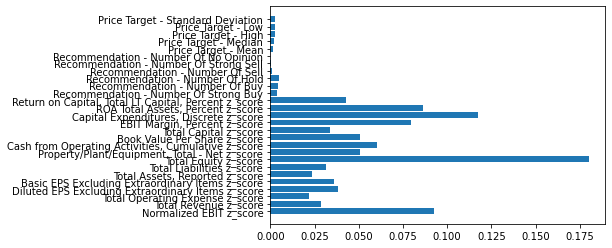

In [16]:
plt.barh(x.columns, importance)
plt.savefig('impor_for.png')

In [17]:
#check the imprtance of each feature in one estimator
importance_tree=forest.estimators_[0].feature_importances_

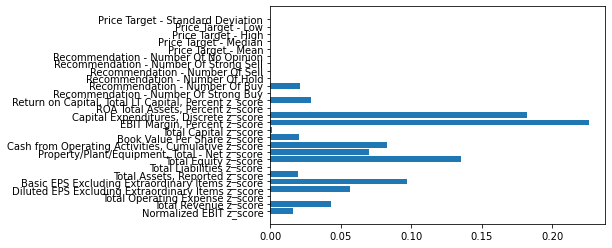

In [18]:
plt.barh(x.columns, importance_tree)
plt.savefig('impor_tree.png')

In [19]:
#output the decision tree graph
export_graphviz(forest.estimators_[0], out_file='tree.dot', feature_names=x.columns, filled=True, rounded=True)

In [20]:
#make predications
y_pred=forest.predict(X_test)

In [21]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 0.19150518130004143
Mean Squared Error: 0.07085950118631894
Root Mean Squared Error: 0.2661944800072288


In [22]:
#try XGboost to see if there is any imporvement
XGBoost=GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, min_samples_split=5,loss='ls', random_state=0)

In [23]:
XGBoost.fit(X_train, Y_train)

GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=300,
                          random_state=0)

In [24]:
XG_pred=XGBoost.predict(X_test)

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, XG_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, XG_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, XG_pred)))
#no significant improvement, therefore only random forest is used in this test

Mean Absolute Error: 0.20675394258031196
Mean Squared Error: 0.0826995805712603
Root Mean Squared Error: 0.28757534764172726


In [26]:
final_ret.loc[final_ret['Year']==2001]

,Company,next_year_return,Year,Normalized EBIT z_score,Total Revenue z_score,Total Operating Expense z_score,Diluted EPS Excluding Extraordinary Items z_score,Basic EPS Excluding Extraordinary Items z_score,"Total Assets, Reported z_score",Total Liabilities z_score,...,Recommendation - Number Of Buy,Recommendation - Number Of Hold,Recommendation - Number Of Sell,Recommendation - Number Of Strong Sell,Recommendation - Number Of No Opinion,Price Target - Mean,Price Target - Median,Price Target - High,Price Target - Low,Price Target - Standard Deviation
0,PKI.N,-1.121942,2001,-0.605386,-0.557569,-0.536046,-0.771089,-0.771228,-0.546933,-0.530570,...,7,3,0,0,0,18.95833,19.50000,19.75000,16.50000,1.12191
1,IT.N,-0.067966,2001,-0.632136,-0.578321,-0.555206,-0.914774,-0.918091,-0.596906,-0.554754,...,9,7,0,0,0,43.13044,44.00000,50.00000,34.00000,4.43606
2,VTR.N,0.045570,2001,-0.617792,-0.605062,-0.585056,-0.664574,-0.667379,-0.594494,-0.549494,...,2,1,1,0,0,27.77886,27.51924,35.30771,20.76924,6.11614
3,CPB.N,-0.202135,2001,-0.285271,-0.400922,-0.407788,-0.341011,-0.345562,-0.477586,-0.379842,...,8,3,0,1,0,59.05809,61.00000,81.00000,33.81612,11.45872
4,GIS.N,-0.063037,2001,-0.281537,-0.412766,-0.421132,-0.493724,-0.490267,-0.497187,-0.417296,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,FMC.N,-0.557466,2001,-0.603040,-0.542159,-0.497010,-1.695724,-1.689916,-0.558488,-0.509054,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
240,F.N,-0.384053,2001,-0.679534,4.174906,4.230500,-1.695724,-1.689916,4.345222,4.478003,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
241,GLW.N,-0.402756,2001,-0.679534,-0.390739,-0.104698,-1.695724,-1.689916,-0.316570,-0.340309,...,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
242,CCK.N,1.739561,2001,-0.561849,-0.348678,-0.284665,-1.695724,-1.689916,-0.390981,-0.292658,...,8,3,0,1,0,59.05809,61.00000,81.00000,33.81612,11.45872


In [27]:
#dynamic approach, updating annual training & testing data
factor_final=pd.DataFrame()
for year in range(2000, 2019):
    final_ret_train = final_ret.loc[final_ret['Year']==year].copy()
    x_train = final_ret_train.drop(['Company', 'next_year_return', 'Year'], axis=1).copy()
    y_train = final_ret_train['next_year_return'].copy()
    final_ret_pred = final_ret.loc[final_ret['Year']==(year+1)].copy()
    x_pred=final_ret_pred.drop(['Company', 'next_year_return', 'Year'], axis=1).copy()
    
    ln_model=sm.OLS(y_train, x_train)
    ln_result=ln_model.fit()
    ln_pred=ln_result.predict(x_pred)
    
    forest.fit(x_train, y_train)
    forest_pred=forest.predict(x_pred)
    
    XGBoost.fit(x_train, y_train)
    XGBoost_pred=XGBoost.predict(x_pred)
    
    final_ret_pred['return_factor_ln']=ln_pred
    final_ret_pred['return_factor_forest']=forest_pred
    final_ret_pred['return_factor_XGB']=XGBoost_pred
    
    factor_final=factor_final.append(final_ret_pred, ignore_index=True)

In [28]:
factor_final

,Company,next_year_return,Year,Normalized EBIT z_score,Total Revenue z_score,Total Operating Expense z_score,Diluted EPS Excluding Extraordinary Items z_score,Basic EPS Excluding Extraordinary Items z_score,"Total Assets, Reported z_score",Total Liabilities z_score,...,Recommendation - Number Of Strong Sell,Recommendation - Number Of No Opinion,Price Target - Mean,Price Target - Median,Price Target - High,Price Target - Low,Price Target - Standard Deviation,return_factor_ln,return_factor_forest,return_factor_XGB
0,PKI.N,-1.121942,2001,-0.605386,-0.557569,-0.536046,-0.771089,-0.771228,-0.546933,-0.530570,...,0,0,18.95833,19.50000,19.75000,16.50000,1.12191,0.047870,0.127703,-0.010086
1,IT.N,-0.067966,2001,-0.632136,-0.578321,-0.555206,-0.914774,-0.918091,-0.596906,-0.554754,...,0,0,43.13044,44.00000,50.00000,34.00000,4.43606,0.311855,0.448800,0.592354
2,VTR.N,0.045570,2001,-0.617792,-0.605062,-0.585056,-0.664574,-0.667379,-0.594494,-0.549494,...,0,0,27.77886,27.51924,35.30771,20.76924,6.11614,0.368840,0.467938,0.494990
3,CPB.N,-0.202135,2001,-0.285271,-0.400922,-0.407788,-0.341011,-0.345562,-0.477586,-0.379842,...,1,0,59.05809,61.00000,81.00000,33.81612,11.45872,0.256393,0.183405,0.122918
4,GIS.N,-0.063037,2001,-0.281537,-0.412766,-0.421132,-0.493724,-0.490267,-0.497187,-0.417296,...,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.057449,0.267273,0.400058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4692,NLY.N,0.077840,2019,-0.679534,-0.579566,-0.467210,-1.505047,-1.501467,2.438999,3.194940,...,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.244368,0.272126,0.111532
4693,EFX.N,0.402343,2019,-0.679534,-0.484432,-0.437379,-1.695724,-1.689916,-0.431106,-0.407680,...,1,0,59.05809,61.00000,81.00000,33.81612,11.45872,0.173247,0.361334,0.360200
4694,LUMN.N,-0.160645,2019,0.588953,0.177861,0.379771,-1.695724,-1.689916,0.901698,1.108360,...,0,0,15.45000,15.50000,16.25000,14.50000,0.64031,0.227665,0.230818,0.314130
4695,BHC.N,-0.138851,2019,-0.244826,-0.296507,-0.235682,-1.695724,-1.689916,0.177547,0.498797,...,1,0,59.05809,61.00000,81.00000,33.81612,11.45872,0.214119,0.344605,0.471771


In [29]:
#function for calculating return
def factor_return(data, ticker_list, year):
    begin = str(year) + "-01-01"
    end = str(year) + "-12-31"
    b_date = pd.to_datetime(begin,format='%Y-%m-%d')
    e_date = pd.to_datetime(end,format='%Y-%m-%d')
    ret_input = data.loc[(data.date>=b_date) & (data.date<=e_date), :].copy()
    ret_input['stat_return']=ret_input[ticker_list].mean(axis=1)
    return ret_input

In [30]:
#generating company selection&calculate return
pick_list_ln = pd.DataFrame()
final_results = pd.DataFrame()
for year in range(2011, 2020):
    factor_year = year
    company_pick_ln=factor_final[factor_final['Year'] == year].copy()
    pick_ln=company_pick_ln.nlargest(20, ['return_factor_ln'])
    pick_ln=pick_ln['Company'].values.tolist()
    
    results=factor_return(ret, pick_ln, year+1)
    final_results=final_results.append(results, ignore_index=True)
    print(pick_ln)

['IBM.N', 'CMI.N', 'WPC.N', 'ELS.N', 'CL.N', 'SCCO.N', 'UPS.N', 'AZO.N', 'LLY.N', 'WMB.N', 'CLX.N', 'TTC.N', 'CPB.N', 'VAR.N', 'BMY.N', 'MCO.N', 'WM.N', 'KMB.N', 'VZ.N', 'MO.N']
['MS.N', 'UPS.N', 'PHM.N', 'WY.N', 'VMC.N', 'PH.N', 'PLD.N', 'SMG.N', 'VTR.N', 'SAM.N', 'RCL.N', 'PKG.N', 'PKI.N', 'UDR.N', 'RPM.N', 'TXT.N', 'WST.N', 'PWR.N', 'PPG.N', 'SHW.N']
['BA.N', 'MCK.N', 'MS.N', 'URI.N', 'IT.N', 'BBY.N', 'LEN.N', 'CAH.N', 'WHR.N', 'AZO.N', 'SAM.N', 'AVY.N', 'BAX.N', 'PG.N', 'KR.N', 'BLK.N', 'MGA.N', 'QGEN.N', 'LMT.N', 'TYL.N']
['MCK.N', 'STZ.N', 'ARE.N', 'VLO.N', 'MS.N', 'PSA.N', 'AVB.N', 'MLM.N', 'MAA.N', 'CVS.N', 'KSU.N', 'WPC.N', 'CAH.N', 'KR.N', 'MHK.N', 'BXP.N', 'VTR.N', 'MCO.N', 'MTD.N', 'LH.N']
['MCK.N', 'ABC.N', 'CAH.N', 'TFX.N', 'LEN.N', 'MO.N', 'MCO.N', 'STZ.N', 'NKE.N', 'LOW.N', 'KR.N', 'CVS.N', 'KMB.N', 'TREX.N', 'LII.N', 'MAS.N', 'SPGI.N', 'MKC.N', 'TJX.N', 'SHW.N']
['COP.N', 'PXD.N', 'CNQ.N', 'PEG.N', 'HES.N', 'WHR.N', 'OXY.N', 'ARE.N', 'BKR.N', 'WMT.N', 'RCL.N', 'WMB.N',

In [31]:
final_results

,date,JPM.N,DIS.N,WMT.N,BA.N,WFC.N,BAC.N,VZ.N,BRKb.N,JNJ.N,...,BMO.N,RPM.N,CCEP.N,HEI.N,GGG.N,BCE.N,SLF.N,TTC.N,QGEN.N,stat_return
0,2012-12-31,0.016883,0.013021,0.009170,0.008970,0.007962,0.021127,0.008625,0.012987,0.008923,...,0.005083,0.013462,0.014062,0.029913,0.012586,0.006092,0.009897,0.025042,0.003872,0.013920
1,2012-12-28,-0.008939,-0.007672,-0.008506,-0.015034,-0.007899,-0.009590,-0.013339,-0.007510,-0.008703,...,-0.003594,0.000345,-0.009810,-0.020509,-0.010508,-0.007673,-0.008305,0.001912,-0.003857,-0.009070
2,2012-12-27,-0.007507,-0.006419,0.002942,-0.002499,-0.004369,-0.006066,0.000690,-0.000448,-0.001140,...,-0.004230,-0.009915,0.000317,-0.000901,-0.011921,-0.000465,-0.002636,0.001196,-0.002199,-0.000321
3,2012-12-26,0.000911,-0.000601,-0.008459,0.000658,-0.002615,0.025778,-0.002067,-0.006345,0.002142,...,-0.002758,0.000000,-0.007852,0.000451,-0.000384,-0.003012,-0.008585,-0.018088,-0.010875,-0.004995
4,2012-12-24,-0.001818,-0.002400,-0.001165,-0.002626,-0.001740,-0.003543,-0.000689,0.000000,-0.003558,...,0.003582,-0.001706,0.005368,0.013702,-0.006872,0.000928,0.000747,0.004720,-0.004870,-0.002365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2020-01-08,0.007801,-0.002059,-0.003432,-0.017523,0.003038,0.010110,0.001846,0.000310,-0.000138,...,0.005834,-0.016673,0.032532,-0.014220,0.004207,0.000860,0.021660,0.009526,0.011715,0.005456
2261,2020-01-07,-0.017001,0.000343,-0.009265,0.010607,-0.008286,-0.006600,-0.011117,-0.004714,0.006107,...,-0.004902,0.002809,-0.036972,0.007576,0.000000,0.000861,0.016347,-0.003329,-0.005675,-0.001116
2262,2020-01-06,-0.000795,-0.005802,-0.002036,0.002945,-0.005990,-0.001433,-0.002152,0.003581,-0.001248,...,0.000904,-0.005190,0.003319,0.007968,0.000766,0.010442,0.007245,0.005330,-0.014134,0.001100
2263,2020-01-03,-0.019491,-0.011471,-0.008828,-0.001680,-0.006140,-0.020763,-0.010647,-0.009676,-0.011578,...,-0.002447,-0.010924,0.005694,0.005760,-0.004572,0.001089,-0.006976,0.004983,0.000884,-0.010482


In [32]:
final_results=final_results[['date', 'stat_return']]
final_results=final_results.sort_values(by='date').reset_index(drop=True)
final_results['cumulative_ret_ln'] = (final_results['stat_return'] + 1).cumprod()
final_results

,date,stat_return,cumulative_ret_ln
0,2012-01-03,0.007709,1.007709
1,2012-01-04,-0.003658,1.004023
2,2012-01-05,0.002631,1.006664
3,2012-01-06,-0.002373,1.004276
4,2012-01-09,0.000866,1.005145
...,...,...,...
2260,2020-12-24,0.004365,3.596723
2261,2020-12-28,-0.001636,3.590841
2262,2020-12-29,-0.006527,3.567404
2263,2020-12-30,0.007769,3.595119


In [33]:
#check ratios for linear model
mean_return=final_results['stat_return'].mean()*250
stdev=final_results['stat_return'].std()*np.sqrt(250)
sharpe_ln=mean_return/stdev
stat_para=pd.DataFrame({'mean_ret':mean_return, 'stdev':stdev, 'sharpe': sharpe_ln}, index=list('a'))
stat_para

,mean_ret,stdev,sharpe
a,0.159439,0.185915,0.857591


In [34]:
pick_list_tree = pd.DataFrame()
final_results_tree = pd.DataFrame()
for year in range(2011, 2020):
    factor_year = year
    company_pick_tree=factor_final[factor_final['Year'] == year].copy()
    pick_tree=company_pick_tree.nlargest(20, ['return_factor_forest'])
    pick_tree=pick_tree['Company'].values.tolist()
    
    results_tree=factor_return(ret, pick_tree, year+1)
    final_results_tree=final_results_tree.append(results_tree, ignore_index=True)
    print(pick_tree)

['FICO.N', 'TYL.N', 'URI.N', 'HEI.N', 'LAD.N', 'MCO.N', 'ROL.N', 'GGG.N', 'TTC.N', 'TJX.N', 'SAM.N', 'TREX.N', 'AZO.N', 'BFb.N', 'DHI.N', 'EL.N', 'SUI.N', 'CLX.N', 'CCK.N', 'CHD.N']
['WHR.N', 'LAD.N', 'TREX.N', 'MAS.N', 'VMC.N', 'KMX.N', 'BSX.N', 'DHI.N', 'MHK.N', 'PHM.N', 'TFX.N', 'TYL.N', 'MGM.N', 'LII.N', 'WY.N', 'NVR.N', 'JCI.N', 'TTC.N', 'PWR.N', 'PKI.N']
['TREX.N', 'BBY.N', 'TYL.N', 'NEM.N', 'HWM.N', 'SAM.N', 'LAD.N', 'MCK.N', 'SYY.N', 'ABC.N', 'CAH.N', 'ADM.N', 'TSN.N', 'KR.N', 'VLO.N', 'AEM.N', 'BHC.N', 'BA.N', 'TTC.N', 'HEI.N']
['KR.N', 'ARE.N', 'BXP.N', 'HWM.N', 'SUI.N', 'WPC.N', 'ELS.N', 'MAA.N', 'ESS.N', 'O.N', 'AVB.N', 'RCL.N', 'UDR.N', 'EQR.N', 'PLD.N', 'VTR.N', 'PEAK.N', 'DRE.N', 'TFX.N', 'MCK.N']
['WST.N', 'BIO.N', 'TYL.N', 'AEM.N', 'LII.N', 'FICO.N', 'ELS.N', 'MTN.N', 'QGEN.N', 'STE.N', 'TTC.N', 'CLX.N', 'SUI.N', 'CRL.N', 'DRE.N', 'BSX.N', 'MAS.N', 'UDR.N', 'ROL.N', 'BFb.N']
['FCX.N', 'HES.N', 'BKR.N', 'HAL.N', 'DVN.N', 'EOG.N', 'PXD.N', 'OXY.N', 'NEM.N', 'COP.N', 'HWM

In [35]:
final_results_tree

,date,JPM.N,DIS.N,WMT.N,BA.N,WFC.N,BAC.N,VZ.N,BRKb.N,JNJ.N,...,BMO.N,RPM.N,CCEP.N,HEI.N,GGG.N,BCE.N,SLF.N,TTC.N,QGEN.N,stat_return
0,2012-12-31,0.016883,0.013021,0.009170,0.008970,0.007962,0.021127,0.008625,0.012987,0.008923,...,0.005083,0.013462,0.014062,0.029913,0.012586,0.006092,0.009897,0.025042,0.003872,0.021247
1,2012-12-28,-0.008939,-0.007672,-0.008506,-0.015034,-0.007899,-0.009590,-0.013339,-0.007510,-0.008703,...,-0.003594,0.000345,-0.009810,-0.020509,-0.010508,-0.007673,-0.008305,0.001912,-0.003857,-0.008741
2,2012-12-27,-0.007507,-0.006419,0.002942,-0.002499,-0.004369,-0.006066,0.000690,-0.000448,-0.001140,...,-0.004230,-0.009915,0.000317,-0.000901,-0.011921,-0.000465,-0.002636,0.001196,-0.002199,-0.000322
3,2012-12-26,0.000911,-0.000601,-0.008459,0.000658,-0.002615,0.025778,-0.002067,-0.006345,0.002142,...,-0.002758,0.000000,-0.007852,0.000451,-0.000384,-0.003012,-0.008585,-0.018088,-0.010875,-0.010817
4,2012-12-24,-0.001818,-0.002400,-0.001165,-0.002626,-0.001740,-0.003543,-0.000689,0.000000,-0.003558,...,0.003582,-0.001706,0.005368,0.013702,-0.006872,0.000928,0.000747,0.004720,-0.004870,-0.000660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2020-01-08,0.007801,-0.002059,-0.003432,-0.017523,0.003038,0.010110,0.001846,0.000310,-0.000138,...,0.005834,-0.016673,0.032532,-0.014220,0.004207,0.000860,0.021660,0.009526,0.011715,0.000213
2261,2020-01-07,-0.017001,0.000343,-0.009265,0.010607,-0.008286,-0.006600,-0.011117,-0.004714,0.006107,...,-0.004902,0.002809,-0.036972,0.007576,0.000000,0.000861,0.016347,-0.003329,-0.005675,0.001383
2262,2020-01-06,-0.000795,-0.005802,-0.002036,0.002945,-0.005990,-0.001433,-0.002152,0.003581,-0.001248,...,0.000904,-0.005190,0.003319,0.007968,0.000766,0.010442,0.007245,0.005330,-0.014134,-0.001048
2263,2020-01-03,-0.019491,-0.011471,-0.008828,-0.001680,-0.006140,-0.020763,-0.010647,-0.009676,-0.011578,...,-0.002447,-0.010924,0.005694,0.005760,-0.004572,0.001089,-0.006976,0.004983,0.000884,-0.004540


In [36]:
final_results_tree=final_results_tree[['date', 'stat_return']]
final_results_tree=final_results_tree.sort_values(by='date').reset_index(drop=True)
final_results_tree['cumulative_ret_tree'] = (final_results_tree['stat_return'] + 1).cumprod()
final_results_tree

,date,stat_return,cumulative_ret_tree
0,2012-01-03,0.004365,1.004365
1,2012-01-04,-0.000982,1.003378
2,2012-01-05,0.007804,1.011208
3,2012-01-06,-0.004492,1.006665
4,2012-01-09,-0.000727,1.005933
...,...,...,...
2260,2020-12-24,0.003799,6.213687
2261,2020-12-28,-0.005438,6.179895
2262,2020-12-29,-0.005992,6.142867
2263,2020-12-30,0.007394,6.188290


In [37]:
#check ratios for random forest
mean_return=final_results_tree['stat_return'].mean()*250
stdev=final_results_tree['stat_return'].std()*np.sqrt(250)
sharpe_tree=mean_return/stdev
stat_tree=pd.DataFrame({'mean_ret':mean_return, 'stdev':stdev, 'sharpe': sharpe_tree}, index=list('b'))
stat_para=stat_para.append(stat_tree)
stat_para

,mean_ret,stdev,sharpe
a,0.159439,0.185915,0.857591
b,0.220353,0.190924,1.154142


In [38]:
pick_list_XGB = pd.DataFrame()
final_results_XGB = pd.DataFrame()
for year in range(2011, 2020):
    factor_year = year
    company_pick_XGB=factor_final[factor_final['Year'] == year].copy()
    pick_XGB=company_pick_XGB.nlargest(20, ['return_factor_XGB'])
    pick_XGB=pick_XGB['Company'].values.tolist()
    
    results_XGB=factor_return(ret, pick_XGB, year+1)
    final_results_XGB=final_results_XGB.append(results_XGB, ignore_index=True)
    print(pick_XGB)

['TYL.N', 'FICO.N', 'TJX.N', 'URI.N', 'HEI.N', 'GWW.N', 'MO.N', 'ED.N', 'CHD.N', 'WPC.N', 'IBM.N', 'TDY.N', 'MCO.N', 'BLL.N', 'MCD.N', 'D.N', 'ROL.N', 'XOM.N', 'ETR.N', 'MMC.N']
['WHR.N', 'LAD.N', 'BSX.N', 'TYL.N', 'LII.N', 'PHM.N', 'MGM.N', 'MHK.N', 'MAS.N', 'TTC.N', 'HD.N', 'JCI.N', 'WY.N', 'MCO.N', 'RMD.N', 'WST.N', 'SMG.N', 'VMC.N', 'LMT.N', 'TXT.N']
['BBY.N', 'TREX.N', 'TYL.N', 'NEM.N', 'SAM.N', 'LAD.N', 'SCHW.N', 'ABC.N', 'TSN.N', 'BA.N', 'MCK.N', 'HWM.N', 'CAH.N', 'LII.N', 'AEM.N', 'TMO.N', 'HEI.N', 'IT.N', 'NOC.N', 'VLO.N']
['UPS.N', 'KR.N', 'TFX.N', 'MO.N', 'SUI.N', 'MGA.N', 'ELS.N', 'KMX.N', 'LAD.N', 'LOW.N', 'HWM.N', 'EQR.N', 'LB.N', 'DTE.N', 'UDR.N', 'SHW.N', 'AZO.N', 'RCL.N', 'ARE.N', 'MAA.N']
['BSX.N', 'VLO.N', 'MLM.N', 'TYL.N', 'ELS.N', 'MTN.N', 'AEM.N', 'BIO.N', 'PWR.N', 'MHK.N', 'HRL.N', 'MKC.N', 'AZO.N', 'WST.N', 'QGEN.N', 'NVR.N', 'LOW.N', 'ROP.N', 'EFX.N', 'BLL.N']
['FCX.N', 'CNQ.N', 'DVN.N', 'TREX.N', 'OXY.N', 'HES.N', 'PXD.N', 'CVX.N', 'PWR.N', 'EOG.N', 'HAL.N', '

In [39]:
final_results_XGB=final_results_XGB[['date', 'stat_return']]
final_results_XGB=final_results_XGB.sort_values(by='date').reset_index(drop=True)
final_results_XGB['cumulative_ret_XGB'] = (final_results_XGB['stat_return'] + 1).cumprod()
final_results_XGB

,date,stat_return,cumulative_ret_XGB
0,2012-01-03,0.000534,1.000534
1,2012-01-04,-0.002923,0.997609
2,2012-01-05,0.005387,1.002983
3,2012-01-06,-0.001029,1.001952
4,2012-01-09,-0.003258,0.998687
...,...,...,...
2260,2020-12-24,0.003866,5.423458
2261,2020-12-28,-0.007928,5.380462
2262,2020-12-29,-0.007002,5.342789
2263,2020-12-30,0.007094,5.380691


In [40]:
mean_return=final_results_XGB['stat_return'].mean()*250
stdev=final_results_XGB['stat_return'].std()*np.sqrt(250)
sharpe_XGB=mean_return/stdev
stat_XGB=pd.DataFrame({'mean_ret':mean_return, 'stdev':stdev, 'sharpe': sharpe_XGB}, index=list('c'))
stat_para=stat_para.append(stat_XGB)
stat_para

,mean_ret,stdev,sharpe
a,0.159439,0.185915,0.857591
b,0.220353,0.190924,1.154142
c,0.203716,0.184678,1.103083


In [41]:
import yfinance as yf

In [42]:
#compare with S&P500
tickers=("^GSPC")
sp_ret = yf.download(tickers, start="2011-12-31", end="2021-01-01")
sp_ret=sp_ret['Adj Close'].copy()
sp_ret[:]=(sp_ret[:]/sp_ret.shift(1)-1)
sp_ret.dropna(inplace=True)
mean_return_sp=sp_ret.mean()*250
stdev_sp=sp_ret.std()*np.sqrt(250)
sharpe_sp=mean_return_sp/stdev_sp
stat_sp=pd.DataFrame({'mean_ret':mean_return_sp, 'stdev':stdev_sp, 'sharpe': sharpe_sp}, index=list('d'))
stat_para=stat_para.append(stat_sp)
stat_para

[*********************100%***********************]  1 of 1 completed


,mean_ret,stdev,sharpe
a,0.159439,0.185915,0.857591
b,0.220353,0.190924,1.154142
c,0.203716,0.184678,1.103083
d,0.133013,0.166070,0.800947


In [43]:
#output the results
#stat_para.to_csv('results.csv')

In [44]:
tickers=("^GSPC")
stock = yf.download(tickers, start="2011-01-02", end="2021-01-01")
stock=stock['Adj Close'].copy()
stock[:]=(stock[:]/stock.iloc[0])#cul return of S&P500
stock

[*********************100%***********************]  1 of 1 completed


Date
2011-01-03    1.000000
2011-01-04    0.998687
2011-01-05    1.003688
2011-01-06    1.001557
2011-01-07    0.999709
                ...   
2020-12-24    2.911508
2020-12-28    2.936904
2020-12-29    2.930362
2020-12-30    2.934294
2020-12-31    2.953187
Name: Adj Close, Length: 2517, dtype: float64

In [45]:
plot_results=final_results.merge(final_results_tree, left_on='date', right_on='date')
plot_results=plot_results.merge(final_results_XGB, left_on='date', right_on='date')

<Figure size 432x288 with 0 Axes>

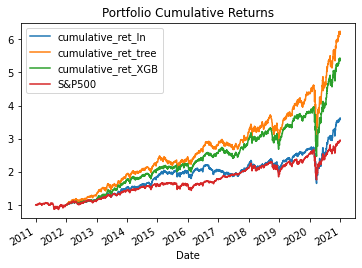

In [46]:
#plot culmulative return
fig = plt.figure()
plot_results.plot(x='date', y=['cumulative_ret_ln', 'cumulative_ret_tree', 'cumulative_ret_XGB'])
stock.plot(x='date', y='S&P500_cul_ret', label="S&P500")
plt.legend(loc="upper left")
plt.title("Portfolio Cumulative Returns")
plt.savefig('cul_return.png')